# **Abstractive Question Answering (QA) on CoQA**

## Abstract

This notebook introduces the NLP task of abstractive question answering (QA) on the Conversational Question Answering (CoQA) dataset released by Stanford NLP in 2019. The notebook uses the 🤗Hugging Face library to create an encoder-decoder transformer architecture and uses pre-trained language model checkpoints to warm-start and fine-tune it



---
---


## Table of Contents

>[Abstractive Question Answering (QA) on CoQA](#scrollTo=K6omrxQx6Fo5)

>>[Abstract](#scrollTo=dCgc97zu6Jf9)

>>[Table of Contents](#scrollTo=WWGx2Bd86JdU)

>>[Background](#scrollTo=VFo1iCjODzkq)

>>>[Question-Answering QA](#scrollTo=2BcF7rdl7BYo)

>>>[CoQA Dataset](#scrollTo=02XPs_qx7DjW)

>>>[Sequence-to-Sequence (Conditional Generation) Tasks](#scrollTo=EXmNiva6wpYH)

>>>[Leveraging Pre-trained Checkpoints for Sequence Generation Tasks](#scrollTo=Gjh6nFK-Czk0)

>>>[Warm-Starting Encoder-Decoder Models](#scrollTo=dE3bADIi0OEi)

>>>[Encoder-Decoder Weight Sharing](#scrollTo=sBhYKOyO2uxf)

>>[Implementation](#scrollTo=C-59QBZd_05f)

>>>[Setup](#scrollTo=rt66QNf9ABFQ)

>>>[Imports](#scrollTo=x4XrRLUdAF0D)

>>>[Download the Dataset](#scrollTo=clfJogfBAann)

>>>[Load the Dataset as Dataframes](#scrollTo=SqWew2FjCpWu)

>>>>[Unanswerable Questions](#scrollTo=dUxELiCf0DP-)

>>>>[Context Lengths](#scrollTo=m31v0mlW4uJR)

>>>>[Answer Lengths](#scrollTo=xkicNapmC-mJ)

>>>>[Train, Validation, Test Splits](#scrollTo=KpS1SV9J174H)

>>>[Load the Dataset as 🤗Dataset](#scrollTo=gilVvYYRF7wR)

>>>[Tokenization](#scrollTo=4cOG42GJ3N1f)

>>>>[Tokenizer Creation](#scrollTo=RP4fTKU-FlbB)

>>>>[Tokenization Example](#scrollTo=Nt6rf680Fr0x)

>>>>[Dataset Tokenization](#scrollTo=ZQgAsebIFt7h)

>>>[Model Creation](#scrollTo=YnTqxO1mFJe5)

>>>[Model Training](#scrollTo=Kr4QfmH3Mfh4)

>>>[Model Generation](#scrollTo=IW2HM0rCtiLO)

>>>[Model Evaluation](#scrollTo=f95fBaznYEhz)

>>>[Error Analysis](#scrollTo=NWf6tt8oG1YT)

>>>[Question-Answering with Dialogue History](#scrollTo=GbQS50X86SBq)

>>>>[Dataset Creation with History](#scrollTo=t_oW3uJ_jya8)

>>>>[Tokenizer Creation](#scrollTo=cT2zbLm-Bmyx)

>>>>[Tokenization Example](#scrollTo=HwPWei3KBmyy)

>>>>[Dataset Tokenization](#scrollTo=SSCmSmg8Bmyy)

>>>>[Model Creation](#scrollTo=GN_KcgYUBmyz)

>>>>[Model Training](#scrollTo=6HF4xSAuBmyz)

>>>>[Model Generation](#scrollTo=Ub74npWeBmyz)

>>>>[Model Evaluation](#scrollTo=VPa-tbWvBmy0)

>>>>[Error Analysis](#scrollTo=A-8htOeXzNxj)

>>[References](#scrollTo=TMZ1gY-mdnri)



---
---
## Background

### Question-Answering QA

Question answering (QA) is a fundamental task in natural language processing (NLP) that involves responding to a question posed in natural language. There are two main approaches to QA: extractive and abstractive. 

- Extractive QA extracts a response from a pre-defined list of options, such as a document or a database. 

- Abstractive QA involves generating a response from scratch, using a combination of understanding the question and its context.

Abstractive QA is of particular interest because it requires a more in-depth understanding of the language and the ability to generate novel text, which makes it a challenging and active area of research in NLP with a wide range of applications.


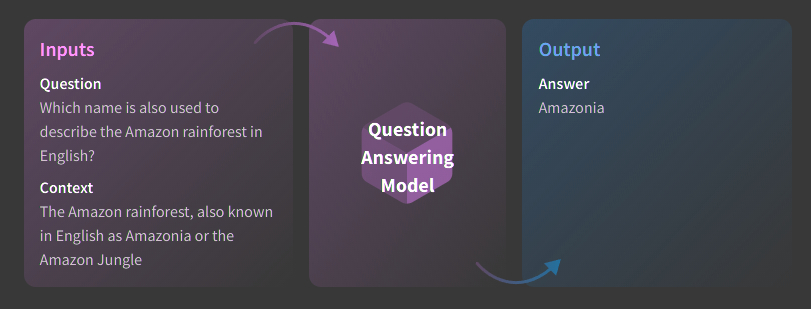

Google's search engine for enquiries is a popular application for question-answering. In this example, Google's search engine retrieved relevant pages and performed an additional processing step to extract the answer snippet with the corresponding passage and web page.

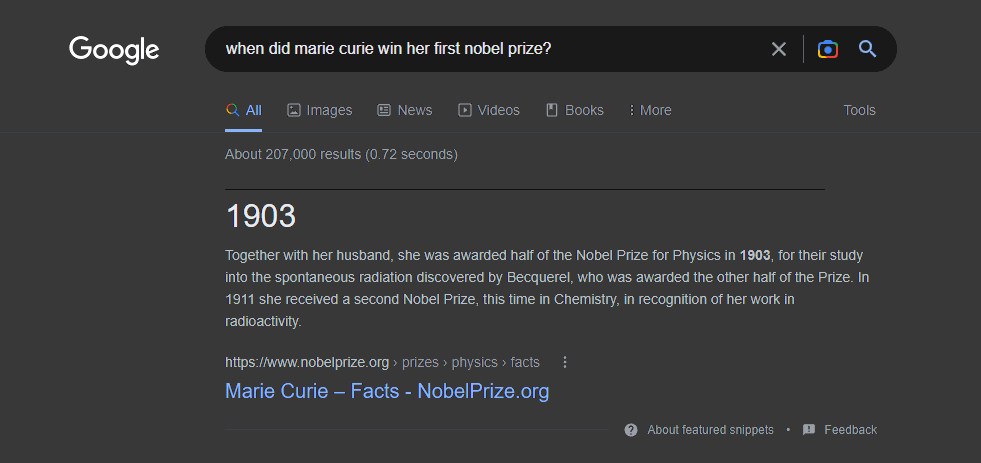

### CoQA Dataset

Stanford university published the paper [CoQA: A Conversational Question Answering Challenge](https://arxiv.org/abs/1808.07042) in 2018. The paper proposes a novel dataset for building conversational question-answering systems containing 127k questions with answers obtained from 8k conversations about text passages from seven diverse domains.

**Dataset Statistics**

- **127k** QA pairs.
- **8k** conversations.
- **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, and Science.
- Average conversation length: **15 turns** (i.e., QA pairs).
- Almost **half** of CoQA questions refer back to **conversational history**.
- Only **train** and **validation** sets are available.
- The dataset contains **unanswerable questions** (around 1%) for which the answer is "unknown".


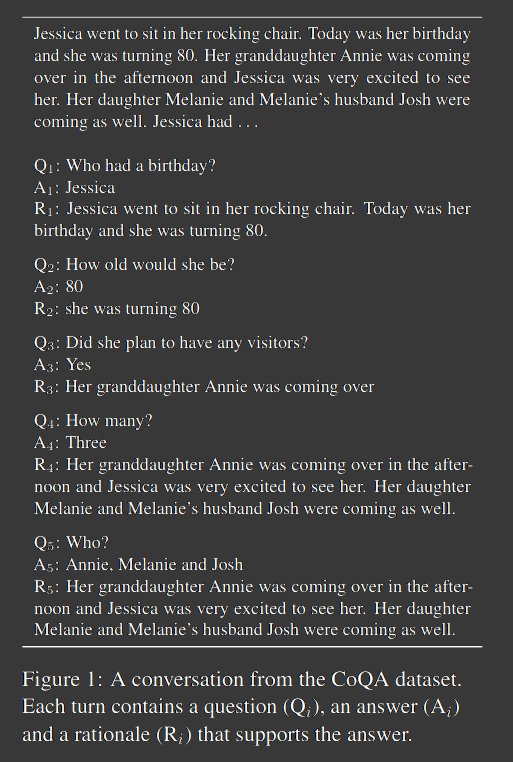

The dataset aims to measure the ability of machines to participate in a question-answering style conversation. In CoQA, a machine has to understand a text passage and answer a series of questions that appear in a conversation. Thus, it was developed with the following goals in mind:

- Dependency on the conversation's history 
  - E.g. the question `Who?` is impossible to answer without knowing what
has already been said).

- Abstract naturalness of answers
  - Many existing QA datasets restrict answers to contiguous
text spans in a given passage. Such answers are not always natural.
  - E.g. there is no span-based answer to the question `How many?`.

- Building QA systems that perform robustly across multiple domains. 

### Sequence-to-Sequence (Conditional Generation) Tasks

Sequence-to-sequence tasks are defined as a mapping from an input sequence $X_{1:n}$ to an output sequence $Y_{1:m}$ of a-priori unknown output length $m$.  Hence, a sequence-to-sequence model should define the conditional probability distribution of the output sequence $Y_{1:m}$ conditioned on the input sequence $X_{1:n}$.

The following sections examine how BERT (encoder only) and GPT-2 (decoder only) could be leveraged to model sequence-to-sequence tasks.

**BERT**

BERT is an encoder-only model that makes use of bi-directional self-attention to map an input sequence to a contextualized encoded sequence. The role of the encoder is to process the input sequence and extract relevant information that will be useful for generating the output sequence. This may involve understanding the relationships between the input tokens, identifying important concepts or entities, and capturing the overall meaning of the input.

Encoder-only models can only map an input sequence to an output sequence of a priori known output length, which makes it disadvantageous and impractical to use for sequence-to-sequence tasks. 

**GPT-2**

GPT2 is a decoder-only model that makes use of uni-directional self-attention. The role of the decoder is to generate the output sequence based on the input representation provided by the encoder. It uses the encoder's contextual representation to predict what tokens to output at each step based on the overall goal of the Seq2Seq task and the input it has received so far.

Therefore, GPT2 is well-suited for language generation but less so for conditional generation due to a fundamental drawback compared to the encoder-decoder architecture: the uni-directional self-attention forces the model's representation of the sequence input to be unnecessarily limited.

### Leveraging Pre-trained Checkpoints for Sequence Generation Tasks

Due to the enormous computational cost of pre-training encoder-decoder models, the development of such models is limited to large companies and institutes.

In [Leveraging Pre-trained Checkpoints for Sequence Generation Tasks (2020)](https://arxiv.org/abs/1907.12461), the authors developed a Transformer-based sequence-to-sequence model that is compatible with publicly available pre-trained BERT, GPT-2 and RoBERTa checkpoints. The authors show that warm-starting encoder-decoder models yield competitive results to large pre-trained encoder-decoder models, such as T5, on multiple sequence-to-sequence tasks at a fraction of the training cost. Warm-starting refers to initializing the encoder-decoder model with a pre-trained encoder and/or decoder-only checkpoints (e.g. BERT, GPT2) to skip the costly pre-training.



### Warm-Starting Encoder-Decoder Models

There are multiple possibilities to warm-start an encoder-decoder model. 

- Initialize only the encoder part with an encoder-only model checkpoint.
- Initialize only the decoder part with an decoder-only model checkpoint.
- Initialize both parts with their corresponding model checkpoint.
- Initialize both parts with an encoder-only model checkpoint.

### Encoder-Decoder Weight Sharing

The authors show that a randomly-initialized encoder-decoder model that shares the encoder's weights with the decoder and therefore reduces the memory footprint by half performs only slightly worse than its "non-shared" version. Sharing the encoder's weights with the decoder means that all layers of the decoder found at the same position in the encoder share the same weight parameters, i.e. the same node in the network's computation graph.

## Implementation

### Setup

This section installs the most recent versions of:

- 🤗Transformers
- 🤗Datasets
- AllenNLP (used for the computation of the SQuAD Macro F1 score)

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.6 MB/s eta 0:00:00


In [2]:
!pip install -q allennlp-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.5/464.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 KB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.6/593.6 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.8 MB/s eta 0

### Imports

In [3]:
# Download the Dataset
import os
import urllib.request

# Dataframe
import numpy as np
import pandas as pd

In [4]:
# Hugging Face
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, EncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Implementation of SQUAD F1-score
from allennlp_models.rc.tools import squad

In [5]:
# Matplotlib
import matplotlib.pyplot as plt

# plt.rcdefaults()
plt.rcParams["figure.facecolor"] = "#383838"
plt.rcParams["axes.facecolor"] = "#383838"

FONT_COLOUR = "white"
plt.rcParams["text.color"] = FONT_COLOUR
plt.rcParams["axes.labelcolor"] = FONT_COLOUR
plt.rcParams["xtick.color"] = FONT_COLOUR
plt.rcParams["ytick.color"] = FONT_COLOUR
plt.rcParams["axes.edgecolor"] = FONT_COLOUR

### Download the Dataset

The following section downloads the CoQA dataset released by Stanford in the form of two JSON files: one for training and another for validation (which is used as a test set).

In [6]:
def download_data(data_path, url_path, split):

  # Create the data directory unless it already exists
  if not os.path.exists(data_path):
    os.makedirs(data_path)      
  
  # Update the data path with the provided data split
  data_path = os.path.join(data_path, f"{split}.json")

  # Download the dataset if it's not already in the data directory
  if not os.path.exists(data_path):
    urllib.request.urlretrieve(url_path, filename=data_path)
    print(f"Downloaded CoQA {split.capitalize()} Dataset.")

  else:
    print(f"{split.capitalize()} Dataset Ready.")

In [7]:
# Train dataset
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path="coqa", url_path=train_url, split="train")

# Val dataset
val_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path="coqa", url_path=val_url, split="val")

Downloaded CoQA Train Dataset.
Downloaded CoQA Val Dataset.


This section examines the downloaded JSON files. Shown below is a single instance from the test dataset. The JSON data has several unnecessary fields. For the purposes of this project, only the `story`, `input_text` from `questions` and `answers` will be used to form the dataframe in the next section.



```
{
  "version": "1.0",
  "data": [
    {
      "source": "mctest",
      "id": "3dr23u6we5exclen4th8uq9rb42tel",
      "filename": "mc160.test.41",
      "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a ...",
      "questions": [
        {
          "input_text": "What color was Cotton?",
          "turn_id": 1
        },
        {
          "input_text": "Where did she live?",
          "turn_id": 2
        },
      ],
      "answers": [
        {
          "span_start": 59,
          "span_end": 93,
          "span_text": "a little white kitten named Cotton",
          "input_text": "white",
          "turn_id": 1
        },
        {
          "span_start": 18,
          "span_end": 80,
          "span_text": "in a barn near a farm house, there lived a little white kitten",
          "input_text": "in a barn",
          "turn_id": 2
        },
      ],
      "additional_answers": {
        "0": [
          {
            "span_start": 68,
            "span_end": 93,
            "span_text": "white kitten named Cotton",
            "input_text": "white",
            "turn_id": 1
          },
          {
            "span_start": 17,
            "span_end": 93,
            "span_text": " in a barn near a farm house, there lived a little white kitten named Cotton",
            "input_text": "in a barn",
            "turn_id": 2
          },
        ],
        "1": [
          {
            "span_start": 68,
            "span_end": 74,
            "span_text": "white ",
            "input_text": "white",
            "turn_id": 1
          },
          {
            "span_start": 18,
            "span_end": 27,
            "span_text": "in a barn",
            "input_text": "in a barn",
            "turn_id": 2
          },
        ],
        "2": [
          {
            "span_start": 68,
            "span_end": 94,
            "span_text": "white kitten named Cotton.",
            "input_text": "white",
            "turn_id": 1
          },
          {
            "span_start": 17,
            "span_end": 94,
            "span_text": " in a barn near a farm house, there lived a little white kitten named Cotton.",
            "input_text": "in a barn near",
            "turn_id": 2
          },
        ]
      },
      "name": "mc160.test.41"
    },
    
  ```



### Load the Dataset as Dataframes

As previously mentioned, this section loads the JSON dataset files into a Pandas dataframes. However, the initial dataframes consist of two columns: `version` and `data`. 

- The `version` column is irrelevant, and is therefore dropped.
- The `data` column contains the `context`, and the `input_text` of the `questions`, and `answers`, with every entry being a complete conversation instance. These instances are split into multiple rows, where each row corresponds to a single QA-pair and its corresponding context.




In [8]:
def json_to_df(json_file_path):

  # Read the json file into an initial df
  df = pd.read_json(json_file_path)

  # Drop the "version" column
  df = df.drop("version", axis=1)

  # Split QA-pairs into rows with shared context
  df_columns = ["Context", "Question", "Answer"]

  # List of lists to populate the new dataframe
  df_rows = []

  # Iterate over rows in the df
  for index, row in df.iterrows():

    # Iterate over QA-pairs
    for i in range(len(row["data"]["questions"])):
      temp_list = []
      temp_list.append(row["data"]["story"])
      temp_list.append(row["data"]["questions"][i]["input_text"])
      temp_list.append(row["data"]["answers"][i]["input_text"])

      df_rows.append(temp_list)

  return pd.DataFrame(df_rows, columns=df_columns) 

In [9]:
# Specify the JSON files path
train_json_file_path = "coqa/train.json"
val_json_file_path = "coqa/val.json"

# Load the Datasets into Dataframes
df_train = json_to_df(train_json_file_path)
df_val = json_to_df(val_json_file_path)

# Display the training set
df_train

,Context,Question,Answer
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law"
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology"
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project
...,...,...,...
108642,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,Xabi Alonso
108643,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,Yes
108644,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,third
108645,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,Barca.


#### Unanswerable Questions

As mentioned above, the answer for certain questions is given as "unknown" indicating that the question cannot be answered. These question-answer pairs are dropped from the dataframe. Certain pairs do still have a rationale despite having "unknown" answer. These instances were also dropped as they are too few to make a considerable difference.

In [10]:
# Remove any row whose Answer value is unknown
df_train_len_pre_removal = len(df_train)
df_train = df_train[df_train["Answer"] != "unknown"]
df_train = df_train.reset_index(drop=True)
print(f"Number of unanswerable QA-pairs in the training set: {df_train_len_pre_removal - len(df_train)}")

df_val_len_pre_removal = len(df_val)
df_val = df_val[df_val["Answer"] != "unknown"]
df_val = df_val.reset_index(drop=True)
print(f"Number of unanswerable QA-pairs in the val set: {df_val_len_pre_removal - len(df_val)}")

Number of unanswerable QA-pairs in the training set: 1371
Number of unanswerable QA-pairs in the val set: 66


<a name="context-lengths"></a>

#### Context Lengths

As shown in the plot below, some of the examples in the dataset have very long contexts that will exceed the maximum length set by the model. This could be dealt with by splitting such examples into multiple training instances with shorter contexts obtained with a sliding window. 

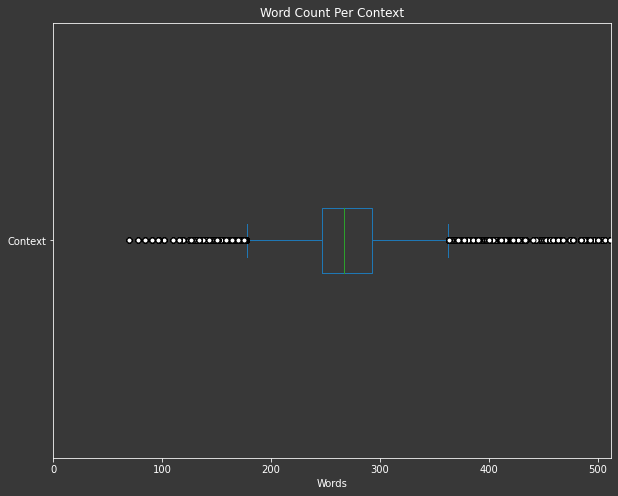

In [11]:
# Visualize the answer lengths
contexts_len = df_train["Context"].str.split(" ").apply(len)
contexts_len.plot.box(
    # Set the Plot Size
    figsize=(10, 8), 
    # Horizontal Box Plot
    vert=False, 
    # Customize the Appearance of Outliers
    flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "white"})

# Limit the x-axis
plt.xlim(0, 512)

# Label the x-axis and set the title of the plot
plt.xlabel("Words")
plt.title("Word Count Per Context")

plt.show()

<a name="answers-lengths"></a>

#### Answer Lengths


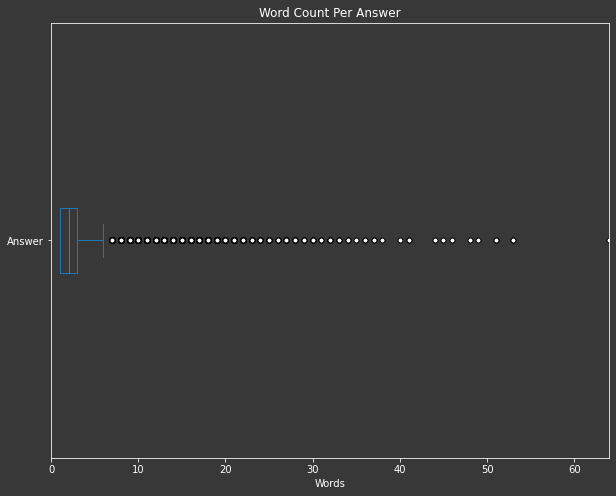

In [12]:
# Visualize the answer lengths
answers_len = df_train["Answer"].str.split(" ").apply(len)
answers_len.plot.box(
    # Set the Plot Size
    figsize=(10, 8), 
    # Horizontal Box Plot
    vert=False, 
    # Customize the Appearance of Outliers
    flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "white"})

# Limit the x-axis
plt.xlim(0, 64)

# Label the x-axis and set the title of the plot
plt.xlabel("Words")
plt.title("Word Count Per Answer")

plt.show()

#### Train, Validation, Test Splits

This section splits the original training set into a new training and validation sets. The splitting is performed such that a conversation can only be in one set. Their percetages are 80%-20%, respectively. 

In [13]:
# Set the seed for reproducibility
seed = 42

# Split the training data into a training set and a validation set, using a 80/20 split
df_train_set = df_train.groupby("Context").sample(frac=0.8, random_state=seed).reset_index(drop=True)
df_val_set = df_train.drop(df_train_set.index).reset_index(drop=True)

# Use the validation data as the test set
df_test_set = df_val

In [14]:
df_train_set

,Context,Question,Answer
0,"""A computer program is a collection of instruc...",What is a part of a computer program that perf...,an algorithm
1,"""A computer program is a collection of instruc...",What is software?,"a collection of computer programs, libraries"
2,"""A computer program is a collection of instruc...",What is another way for a program to execute c...,with the aid of an interpreter
3,"""A computer program is a collection of instruc...",Did programmable machines precede the inventio...,yes
4,"""A computer program is a collection of instruc...","What was the ""mill"" analogous to?",to the CPU of a modern machine
...,...,...,...
85770,"zbMATH, formerly Zentralblatt MATH, is a major...",Whom?,Niels Bohr
85771,"zbMATH, formerly Zentralblatt MATH, is a major...",Was anyone famous related to the project?,yes
85772,"zbMATH, formerly Zentralblatt MATH, is a major...",That was formerly known as?,Zentralblatt MATH
85773,"zbMATH, formerly Zentralblatt MATH, is a major...",Where did he work?,Copenhagen


In [15]:
df_val_set

,Context,Question,Answer
0,Einstein's connection with the politics of the...,Who signed a note to President Franklin?,Einstein
1,Einstein's connection with the politics of the...,What was he so upset about in WWI?,the waste of human lives
2,Einstein's connection with the politics of the...,So what did he do about it?,became involved in antiwar demonstrations
3,Einstein's connection with the politics of the...,Then what did he do after the war?,reconciliation and improving international rel...
4,Einstein's connection with the politics of the...,What group did he finally identify with?,Zionism.
...,...,...,...
21496,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,Xabi Alonso
21497,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,Yes
21498,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,third
21499,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,Barca.


In [16]:
df_test_set

,Context,Question,Answer
0,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,white
1,"Once upon a time, in a barn near a farm house,...",Where did she live?,in a barn
2,"Once upon a time, in a barn near a farm house,...",Did she live alone?,no
3,"Once upon a time, in a barn near a farm house,...",Who did she live with?,with her mommy and 5 sisters
4,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,orange and white
...,...,...,...
7912,"Las Vegas (, Spanish for ""The Meadows""), offic...","where does the nickname ""Sin City"" come from?",The city's tolerance for numerous forms of adu...
7913,"Las Vegas (, Spanish for ""The Meadows""), offic...",Which state is it in?,Nevada
7914,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,Yes
7915,"Las Vegas (, Spanish for ""The Meadows""), offic...",what is the name of the desert?,Mojave Desert.


### Load the Dataset as `🤗Dataset`

`🤗Datasets` is a library that enables efficient and scalable processing of large amounts of data. It uses `Arrow` as a local caching system, allowing datasets to be backed by an on-disk cache that is memory-mapped for fast lookup. This architecture allows large datasets to be used on machines with relatively small device memory. `🤗Datasets` support a wide range of data types and are compatible with various machine learning libraries, such as PyTorch and TensorFlow. It is designed to make it easy to use large datasets in machine learning applications and to enable fast and efficient data processing.

This section creates a dictionary of datasets using the `DatasetDict` class from `🤗Datasets`. The dictionary contains three datasets: "train", "val", and "test", each created using the `from_pandas` method of the `Dataset` class, which takes a Pandas DataFrame as input and outputs it as a dataset object. The DataFrames passed are `df_train_set`, `df_val_set`, and `df_test_set`, which are the training, validation, and test sets, respectively.

The resulting `DatasetDict` object, `ds`, will contain the three datasets, which can be accessed using the keys "train", "val", and "test". This is done to organize and manage the datasets and to take advantage of Hugging Face's efficient processing methods.

In [17]:
# Create a 🤗DatasetDict object with the three data splits
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train_set), 
    "val": Dataset.from_pandas(df_val_set), 
    "test": Dataset.from_pandas(df_test_set)
    })

ds

DatasetDict({
    train: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 85775
    })
    val: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 21501
    })
    test: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 7917
    })
})

In [18]:
# Create a 🤗DatasetDict object with the three data splits

"""
Due to the limited computational resources of a Colab notebook,
training on the entire dataset is quite difficult. Thus,
only half of the training set is considered. Additionally,
only a small amount of validation, and test sets are used
as the evaluation process is much more time-consuming.
"""
n_train = 40000
n_val = 2000
n_test = 2000
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train_set.iloc[:n_train]), 
    "val": Dataset.from_pandas(df_val_set.iloc[:n_val]), 
    "test": Dataset.from_pandas(df_test_set.iloc[:n_test])
    })

ds

DatasetDict({
    train: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['Context', 'Question', 'Answer'],
        num_rows: 2000
    })
})

In [19]:
# Example
ds["train"][0]

{'Context': '"A computer program is a collection of instructions that performs a specific task when executed by a computer". A computer requires programs to function and typically executes the program\'s instructions in a central processing unit. \n\nA computer program is usually written by a computer programmer in a programming language. From the program in its human-readable form of source code, a compiler can derive machine code—a form consisting of instructions that the computer can directly execute. Alternatively, a computer program may be executed with the aid of an interpreter. \n\nA part of a computer program that performs a well-defined task is known as an algorithm. A collection of computer programs, libraries, and related data are referred to as software. Computer programs may be categorized along functional lines, such as application software or system software. \n\nThe earliest programmable machines preceded the invention of the digital computer. In 1801, Joseph-Marie Jacq

### Tokenization

`🤗Tokenizers` is a library for tokenizing natural language text focused on performance and versatility. It provides implementations of several popular tokenizers. `🤗Tokenizers` can handle pre-processing tasks such as truncation, padding, and adding special tokens.

#### Tokenizer Creation

In [20]:
# Tokenizer Hyperparameters
batch_size = 64
encoder_max_length = 256
decoder_max_length = 8

# Specify the model checkpoint
checkpoint_distilroberta = "distilroberta-base"

# Instantiate the appropriate tokenizer
tokenizer_distilroberta = AutoTokenizer.from_pretrained(checkpoint_distilroberta)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

The following cell defines a function, `process_batch_to_model_inputs`, that takes a batch of data as input and processes it for use as input to the transformer model. The batch is expected to contain the following keys: `Question`, `Context`, and `Answer`.

The function begins by concatenating and tokenizing the `Question` and `Context` fields and adding the necessary special tokens. The `Answer` is tokenized as well. The tokenized input and output sequences are then added to the batch as the keys `input_ids`, `attention_mask`, and `labels`.

The `labels` key has the PAD token replaced with a special value (-100) for the PAD token to be ignored when computing the evaluation metric. 

In [21]:
def process_batch_to_model_inputs(batch):

  # tokenize the inputs and labels
  inputs = tokenizer_distilroberta(batch["Question"], batch["Context"], padding="max_length", truncation="only_second", max_length=encoder_max_length)
  outputs = tokenizer_distilroberta(batch["Answer"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT-based transformers automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # Make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer_distilroberta.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

#### Tokenization Example

In [22]:
# Extract an example sample (context, question) pairs and answers
n = 1
example_contexts = ds["train"][n]["Context"]
example_questions = ds["train"][n]["Question"]
example_answers = ds["train"][n]["Answer"]

# Tokenize the (context, question) pair
inputs = tokenizer_distilroberta(
  example_questions,
  example_contexts,
  max_length=encoder_max_length,
  truncation="only_second",
  padding="max_length"
)

outputs = tokenizer_distilroberta(
  example_answers,
  max_length=decoder_max_length,
  padding="max_length"
)

# Print the De-tokenized Input (C, Q) pairs
print(tokenizer_distilroberta.decode(inputs["input_ids"]))

# Print the De-tokenized Output (A)
print("-" * 40)
print(tokenizer_distilroberta.decode(outputs["input_ids"]))

<s>What is software?</s></s>"A computer program is a collection of instructions that performs a specific task when executed by a computer". A computer requires programs to function and typically executes the program's instructions in a central processing unit. 

A computer program is usually written by a computer programmer in a programming language. From the program in its human-readable form of source code, a compiler can derive machine code—a form consisting of instructions that the computer can directly execute. Alternatively, a computer program may be executed with the aid of an interpreter. 

A part of a computer program that performs a well-defined task is known as an algorithm. A collection of computer programs, libraries, and related data are referred to as software. Computer programs may be categorized along functional lines, such as application software or system software. 

The earliest programmable machines preceded the invention of the digital computer. In 1801, Joseph-Ma

#### Dataset Tokenization

The map method of the `🤗Datasets` library is a powerful tool for pre-processing and augmenting data in transformer pipelines. It allows one to apply a function to each element of a dataset and create a new dataset with the transformed elements, which is useful for tasks such as tokenization, normalization, and adding additional features to the data.

The following section uses the `.map()` method to apply the `process_batch_to_model_inputs` function to each element in the `ds` dataset. The `process_batch_to_model_inputs` function is a custom function that takes a batch of data as input and processes it for use as input to the transformer model. The modified batches are returned by the function and are used to create a new dataset.

The `.map()` method also takes several optional arguments, such as `batched`, `batch_size`, and `remove_columns`. The batched argument specifies whether the function should be applied in batches, and the `batch_size ` argument specifies their size. The `remove_columns` argument specifies a list of columns to remove from the dataset after the function has been applied.

In [23]:
ds = ds.map(
    process_batch_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["Context", "Question", "Answer"]
)

ds

  0%|          | 0/625 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

### Model Creation

The `EncoderDecoderModel` from `🤗Transformers` can initialize a sequence-to-sequence model with pre-trained models as the encoder and decoder, which is useful for leveraging the knowledge learned by these checkpoints downstream NLP seq2seq tasks.

In the code above, an `EncoderDecoderModel` is instantiated using the `from_encoder_decoder_pretrained` method and the pre-trained checkpoints of the `DistilRoBERTa` model. The `tie_encoder_decoder` argument specifies that the encoder and decoder should share weights, which can improve its efficiency.

In [24]:
# Instantiate a RoBERTa2RoBERTa Encoder-Decoder Model with Weight Sharing
shared_distilroberta = EncoderDecoderModel.from_encoder_decoder_pretrained(
    checkpoint_distilroberta, checkpoint_distilroberta, 
    tie_encoder_decoder=True)

# Configure the model special tokens to the RoBERTa tokenizer
shared_distilroberta.config_eos_token_id = tokenizer_distilroberta.sep_token_id
shared_distilroberta.config.pad_token_id = tokenizer_distilroberta.pad_token_id
shared_distilroberta.config.vocab_size = shared_distilroberta.config.encoder.vocab_size
shared_distilroberta.config.decoder_start_token_id = tokenizer_distilroberta.cls_token_id

# Configure the model generation parameters
shared_distilroberta.config.num_beams = 4
shared_distilroberta.config.min_length = 1
shared_distilroberta.config.length_penalty = 3.0
shared_distilroberta.config.early_stopping = True
shared_distilroberta.config.no_repeat_ngram_size = 3
shared_distilroberta.config.max_length = decoder_max_length

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.2.crossattention.self.key.weight', 'roberta.encoder.layer.3.crossattention.o

### Model Training

The following cell defines a function that will compute the SQuAD Macro F1 during training.

In [25]:
def compute_metrics(pred):

  # Get the ground truth labels and predicted labels
  label_ids = pred.label_ids
  pred_ids = pred.predictions
  
  # Decode the label IDs and predicted IDs
  pred_list = tokenizer_distilroberta.batch_decode(pred_ids, skip_special_tokens=True)
  label_ids[label_ids == -100] = tokenizer_distilroberta.pad_token_id
  label_list = tokenizer_distilroberta.batch_decode(label_ids, skip_special_tokens=True)

  squad_f1_scores = []
  for pred_str, label_str in zip(pred_list, label_list):
    squad_f1_scores.append(squad.compute_f1(pred_str, label_str))

  return {"SQuAD-F1": np.mean(squad_f1_scores)}

The `Seq2SeqTrainer` extends `🤗Transformer`'s Trainer for encoder-decoder models. In short, it allows using the `generate()` function during evaluation, which is necessary to validate the performance of encoder-decoder models on most sequence-to-sequence tasks. It also allows one to specify a seed for training.

In [26]:
# Arguments for training the model
training_args = Seq2SeqTrainingArguments(
    
  # Use the generate method for prediction
  predict_with_generate=True,

  # Evaluation should be done by number of steps
  evaluation_strategy="epoch",
 
  # Batch size for training
  per_device_train_batch_size=batch_size,
 
  # Batch size for evaluation
  per_device_eval_batch_size=batch_size,
 
  # Use FP16 precision
  fp16=True,

  # Output directory for saving models and evaluation results
  output_dir="./",

  # Log training progress every 10 steps
  logging_steps=100,
 
  # Reproducability Seed
  seed = 42,

  # Logging results
  report_to="none"
)

In [27]:
# Initialize the trainer
trainer = Seq2SeqTrainer(
  
  # The model to be trained
  model=shared_distilroberta,

  # The tokenizer for the model
  tokenizer=tokenizer_distilroberta,

  # Training arguments
  args=training_args,

  # Function for computing evaluation metrics
  compute_metrics=compute_metrics,

  # Training data
  train_dataset=ds["train"],
  
  # Validation data
  eval_dataset=ds["val"],
)

# Start fine-tuning
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decod

Epoch,Training Loss,Validation Loss,Squad-f1
1,3.956000,3.670691,0.104500
2,3.227900,3.045410,0.136453
3,2.976100,2.926130,0.151313


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config

TrainOutput(global_step=1875, training_loss=3.6176739095052084, metrics={'train_runtime': 1415.4394, 'train_samples_per_second': 84.779, 'train_steps_per_second': 1.325, 'total_flos': 1.068045502464e+16, 'train_loss': 3.6176739095052084, 'epoch': 3.0})

### Model Generation

In [28]:
def generate_answer(batch):

    input_ids = np.array(batch["input_ids"])
    attention_mask = np.array(batch["attention_mask"])

    outputs = shared_distilroberta.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer_distilroberta.batch_decode(outputs, skip_special_tokens=True)

    return output_str

In [29]:
df_rows = []
for i in range(100):
  ex = df_test_set.iloc[i]
  ex_context = ex["Context"]
  ex_question = ex["Question"]
  ex_answer = ex["Answer"]


  ex_inputs = tokenizer_distilroberta(ex_question, ex_context, return_tensors="pt", padding="max_length", truncation="only_second", max_length=encoder_max_length)
  ex_input_ids = ex_inputs.input_ids.to("cuda")
  ex_attention_mask = ex_inputs.attention_mask.to("cuda")

  outputs = shared_distilroberta.generate(ex_input_ids, attention_mask=ex_attention_mask)
  output_str = tokenizer_distilroberta.batch_decode(outputs, skip_special_tokens=True)

  df_rows.append({
      "Question": ex_question,
       "Prediction": output_str[0],
       "Answer": ex_answer
      })
  
df_answers = pd.DataFrame(df_rows)
df_answers

,Question,Prediction,Answer
0,What color was Cotton?,brown,white
1,Where did she live?,in the park.,in a barn
2,Did she live alone?,yes,no
3,Who did she live with?,a young girl,with her mommy and 5 sisters
4,What color were her sisters?,brown,orange and white
...,...,...,...
95,What were they hit by?,A tree,"Glass, wood, plaster, and maybe the washing ma..."
96,Was RJ badly hurt?,yes,No
97,Who was hurt the worst?,Sammy,Eppes
98,What guided RJ home?,a tree,The flashlight


### Model Evaluation

In [30]:
def squad_f1(label_list, pred_list):

  squad_f1_scores = []
  for pred_str, label_str in zip(pred_list, label_list):
    squad_f1_scores.append(squad.compute_f1(pred_str, label_str))

  return {"SQuAD-F1": np.mean(squad_f1_scores)}

In [31]:
print("Test Set Performance:")
squad_f1(df_answers["Prediction"].tolist(), df_answers["Answer"].tolist())

Test Set Performance:


{'SQuAD-F1': 0.19471428571428573}

### Error Analysis 

In [32]:
def json_to_df_w_source(json_file_path):

  # Read the json file into an initial df
  df = pd.read_json(json_file_path)

  # Drop the "version" column
  df = df.drop("version", axis=1)

  # Split QA-pairs into rows with shared context
  df_columns = ["Context", "Question", "Answer", "Source"]

  # List of lists to populate the new dataframe
  df_rows = []

  # Iterate over rows in the df
  for index, row in df.iterrows():

    # Iterate over QA-pairs
    for i in range(len(row["data"]["questions"])):
      temp_list = []
      temp_list.append(row["data"]["story"])
      temp_list.append(row["data"]["questions"][i]["input_text"])
      temp_list.append(row["data"]["answers"][i]["input_text"])
      temp_list.append(row["data"]["source"])
      
      df_rows.append(temp_list)

  return pd.DataFrame(df_rows, columns=df_columns) 

# Load the Datasets into Dataframes
df_w_source = json_to_df_w_source(val_json_file_path)

In [33]:
def worst_5_errors(y_true, y_pred):

  f1_scores = []
  for i in range(len(y_true)):

    # Compute F1 for the current example
    f1_score = squad_f1(y_true[i], y_pred[i])
    f1_scores.append(f1_score)

  # Use argpartition to get the indices of the 5 smallest elements
  f1_scores = [d["SQuAD-F1"] for d in f1_scores]
  worst_5_indices = np.argpartition(f1_scores, 5)[:5]
  return worst_5_indices, [y_pred[i] for i in worst_5_indices]

In [34]:
# GroupBy Source
df_grouped_by_source = df_w_source.groupby("Source")

encoder_max_length = 256
df_results = pd.DataFrame()
for group_name, group in df_grouped_by_source:

  group = group[:20]

  # Tokenize the group
  inputs = tokenizer_distilroberta(group["Question"].tolist(), group["Context"].tolist(), padding="max_length", truncation="only_second", return_tensors="pt", max_length=encoder_max_length)
  outputs = tokenizer_distilroberta(group["Answer"].tolist(), padding="max_length", return_tensors="pt", truncation=True, max_length=decoder_max_length)
  input_ids = inputs.input_ids.to("cuda")
  attention_mask = inputs.attention_mask.to("cuda")

  # Generate answers
  generated_output = shared_distilroberta.generate(input_ids, attention_mask=attention_mask)
  pred_list = tokenizer_distilroberta.batch_decode(generated_output, skip_special_tokens=True)
  
  # Compute the F1 Score/Source
  worst_5_indices, worst_5_predictions = worst_5_errors(group["Answer"].tolist(), pred_list)
  df_temp = df_grouped_by_source.get_group(group_name).reset_index(drop=True).loc[worst_5_indices]
  df_temp["Prediction"] = worst_5_predictions
  df_results = pd.concat([df_results, df_temp])

df_results

,Context,Question,Answer,Source,Prediction
12,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Who did he portray?,Detective Joe Fontana,cnn,Alfred Hitchcock.
16,"(CNN) -- Dennis Farina, the dapper, mustachioe...",What were they like?,Flashy,cnn,a young man
15,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Were the characters clothes frumpy?,No,cnn,yes
13,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Did he have a beater for a car?,No,cnn,yes
17,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Was he on the show for five years?,No,cnn,yes
1,"CHAPTER XXII \n\nNorthward, along the leeward ...",What lay between the shore-reefs and outer-reefs?,Lagoon,gutenberg,the coast of the sea
9,"CHAPTER XXII \n\nNorthward, along the leeward ...",What ship had Haggin sailed on?,The Arangi,gutenberg,a shipboat
16,"CHAPTER XXII \n\nNorthward, along the leeward ...",Did she ask Villa to think of her being called...,No,gutenberg,yes
12,"CHAPTER XXII \n\nNorthward, along the leeward ...",Did she tell him to think of himself being in ...,No,gutenberg,yes
19,"CHAPTER XXII \n\nNorthward, along the leeward ...",Were there cannibals?,unknown,gutenberg,yes


### Question-Answering with Dialogue History

#### Dataset Creation with History

In [35]:
def group_to_history(group):

  # Initialize an empty list to store the histories
  histories_list = []

  # Initialize an empty string to store the incremental history
  incremental_history = ""

  # Add the empty string to the list of histories
  histories_list.append(incremental_history)

  # Iterate over the rows in the group DataFrame
  for index, row in group.iterrows():
  
    # Get the values of the "Question" and "Answer" columns
    q = row["Question"]
    a = row["Answer"]

    # Concatenate the "Question" and "Answer" values with a period separator and append the result to the incremental history
    incremental_history += f"{q} {a}. "

    # Append the incremental history to the list of histories
    histories_list.append(incremental_history)
  
  # Return the list of histories, excluding the final element (which is the concatenation of all the histories)
  return histories_list[:-1]

In [36]:
def context_to_history(df, n):

  # Make a copy of the first n rows of the DataFrame
  df = df.iloc[:n].copy()

  # Initialize an empty list to store the histories
  histories = []

  # Iterate over the groups in the DataFrame, grouped by the 'Context' column
  for _, group in df.groupby("Context"):

    # Get the histories for the group
    group_histories = group_to_history(group)

    # Add the group histories to the list of histories
    histories.extend(group_histories)

  # Add the histories to the DataFrame as a new column
  df["History"] = histories
  
  # Use the 'apply' function with a lambda function to concatenate the 'History' and 'Context' columns
  df["History"] = df.apply(lambda row: row["History"] + " " + row["Context"], axis=1)

  # Return the DataFrame with the 'Context' column dropped
  return df.drop("Context", axis=1)

In [37]:
n_train = 20000
n_val = 1000
n_test = 1000

df_train_set_w_history = context_to_history(df_train_set, n_train)
df_val_set_w_history = context_to_history(df_val_set, n_val)
df_test_set_w_history = context_to_history(df_test_set, n_test)

df_train_set_w_history

,Question,Answer,History
0,What is a part of a computer program that perf...,an algorithm,"""A computer program is a collection of instru..."
1,What is software?,"a collection of computer programs, libraries",What is a part of a computer program that perf...
2,What is another way for a program to execute c...,with the aid of an interpreter,What is a part of a computer program that perf...
3,Did programmable machines precede the inventio...,yes,What is a part of a computer program that perf...
4,"What was the ""mill"" analogous to?",to the CPU of a modern machine,What is a part of a computer program that perf...
...,...,...,...
19995,What's the largest city there?,Santa Cruz de la Sierra,What country has agreements giving it access t...
19996,How much of the country is made up of a mounta...,One-third,What country has agreements giving it access t...
19997,Is it direct access?,no,What country has agreements giving it access t...
19998,Then what?,indirect,What country has agreements giving it access t...


In [38]:
# Create a 🤗DatasetDict object with the three data splits
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train_set_w_history), 
    "val": Dataset.from_pandas(df_val_set_w_history), 
    "test": Dataset.from_pandas(df_test_set_w_history)
    })

ds

DatasetDict({
    train: Dataset({
        features: ['Question', 'Answer', 'History'],
        num_rows: 20000
    })
    val: Dataset({
        features: ['Question', 'Answer', 'History'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['Question', 'Answer', 'History'],
        num_rows: 1000
    })
})

#### Tokenizer Creation

In [39]:
# Tokenizer Hyperparameters
batch_size = 32
encoder_max_length = 512
decoder_max_length = 8

# Specify the model checkpoint
checkpoint_distilroberta = "distilroberta-base"

# Instantiate the appropriate tokenizer
tokenizer_distilroberta = AutoTokenizer.from_pretrained(checkpoint_distilroberta)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,


In [40]:
def process_batch_to_model_inputs(batch):

  # tokenize the inputs and labels
  inputs = tokenizer_distilroberta(batch["Question"], batch["History"], padding="max_length", truncation="only_second", max_length=encoder_max_length)
  outputs = tokenizer_distilroberta(batch["Answer"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT-based transformers automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # Make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer_distilroberta.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

#### Tokenization Example

In [41]:
# Extract an example sample (history, question) pairs and answers
n = 1
example_contexts = ds["train"][n]["History"]
example_questions = ds["train"][n]["Question"]
example_answers = ds["train"][n]["Answer"]

# Tokenize the (history, question) pair
inputs = tokenizer_distilroberta(
  example_questions,
  example_contexts,
  max_length=encoder_max_length,
  truncation="only_second",
  padding="max_length"
)

outputs = tokenizer_distilroberta(
  example_answers,
  max_length=decoder_max_length,
  padding="max_length"
)

# Print the De-tokenized Input (C, Q) pairs
print(tokenizer_distilroberta.decode(inputs["input_ids"]))

# Print the De-tokenized Output (A)
print("-" * 40)
print(tokenizer_distilroberta.decode(outputs["input_ids"]))

<s>What is software?</s></s>What is a part of a computer program that performs a defined task? an algorithm.  "A computer program is a collection of instructions that performs a specific task when executed by a computer". A computer requires programs to function and typically executes the program's instructions in a central processing unit. 

A computer program is usually written by a computer programmer in a programming language. From the program in its human-readable form of source code, a compiler can derive machine code—a form consisting of instructions that the computer can directly execute. Alternatively, a computer program may be executed with the aid of an interpreter. 

A part of a computer program that performs a well-defined task is known as an algorithm. A collection of computer programs, libraries, and related data are referred to as software. Computer programs may be categorized along functional lines, such as application software or system software. 

The earliest progra

#### Dataset Tokenization

The map method of the `🤗Datasets` library is a powerful tool for pre-processing and augmenting data in transformer pipelines. It allows one to apply a function to each element of a dataset and create a new dataset with the transformed elements, which is useful for tasks such as tokenization, normalization, and adding additional features to the data.

The following section uses the `.map()` method to apply the `process_batch_to_model_inputs` function to each element in the `ds` dataset. The `process_batch_to_model_inputs` function is a custom function that takes a batch of data as input and processes it for use as input to the transformer model. The modified batches are returned by the function and are used to create a new dataset.

The `.map()` method also takes several optional arguments, such as `batched`, `batch_size`, and `remove_columns`. The batched argument specifies whether the function should be applied in batches, and the `batch_size ` argument specifies their size. The `remove_columns` argument specifies a list of columns to remove from the dataset after the function has been applied.

In [42]:
ds = ds.map(
    process_batch_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["History", "Question", "Answer"]
)

ds

  0%|          | 0/625 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

#### Model Creation

The `EncoderDecoderModel` from `🤗Transformers` can initialize a sequence-to-sequence model with pre-trained models as the encoder and decoder, which is useful for leveraging the knowledge learned by these checkpoints downstream NLP seq2seq tasks.

In the code above, an `EncoderDecoderModel` is instantiated using the `from_encoder_decoder_pretrained` method and the pre-trained checkpoints of the `DistilRoBERTa` model. The `tie_encoder_decoder` argument specifies that the encoder and decoder should share weights, which can improve its efficiency.

In [43]:
# Instantiate a RoBERTa2RoBERTa Encoder-Decoder Model with Weight Sharing
shared_distilroberta = EncoderDecoderModel.from_encoder_decoder_pretrained(
    checkpoint_distilroberta, checkpoint_distilroberta, 
    tie_encoder_decoder=True)

# Configure the model special tokens to the RoBERTa tokenizer
shared_distilroberta.config_eos_token_id = tokenizer_distilroberta.sep_token_id
shared_distilroberta.config.pad_token_id = tokenizer_distilroberta.pad_token_id
shared_distilroberta.config.vocab_size = shared_distilroberta.config.encoder.vocab_size
shared_distilroberta.config.decoder_start_token_id = tokenizer_distilroberta.cls_token_id

# Configure the model generation parameters
shared_distilroberta.config.num_beams = 4
shared_distilroberta.config.min_length = 1
shared_distilroberta.config.length_penalty = 3.0
shared_distilroberta.config.early_stopping = True
shared_distilroberta.config.no_repeat_ngram_size = 3
shared_distilroberta.config.max_length = decoder_max_length

loading configuration file https://huggingface.co/distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/dis

#### Model Training

In [44]:
# Arguments for training the model
training_args = Seq2SeqTrainingArguments(
    
  # Use the generate method for prediction
  predict_with_generate=True,

  # Evaluation should be done by number of steps
  evaluation_strategy="epoch",
 
  # Batch size for training
  per_device_train_batch_size=batch_size,
 
  # Batch size for evaluation
  per_device_eval_batch_size=batch_size,
 
  # Use FP16 precision
  fp16=True,

  # Output directory for saving models and evaluation results
  output_dir="./",

  # Log training progress every 10 steps
  logging_steps=100,
 
  # Reproducability Seed
  seed = 42,

  # Logging results
  report_to="none"
)

PyTorch: setting up devices


In [45]:
# Initialize the trainer
trainer = Seq2SeqTrainer(
  
  # The model to be trained
  model=shared_distilroberta,

  # The tokenizer for the model
  tokenizer=tokenizer_distilroberta,

  # Training arguments
  args=training_args,

  # Function for computing evaluation metrics
  compute_metrics=compute_metrics,

  # Training data
  train_dataset=ds["train"],
  
  # Validation data
  eval_dataset=ds["val"],
)

# Start fine-tuning
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decod

Epoch,Training Loss,Validation Loss,Squad-f1
1,4.369300,4.139054,0.108000
2,3.846100,3.735843,0.108000
3,3.386300,3.492587,0.110067


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config

TrainOutput(global_step=1875, training_loss=4.086030696614583, metrics={'train_runtime': 1580.2978, 'train_samples_per_second': 37.968, 'train_steps_per_second': 1.186, 'total_flos': 1.068045502464e+16, 'train_loss': 4.086030696614583, 'epoch': 3.0})

#### Model Generation

In [46]:
def generate_answer(batch):

    input_ids = np.array(batch["input_ids"])
    attention_mask = np.array(batch["attention_mask"])

    outputs = shared_distilroberta.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer_distilroberta.batch_decode(outputs, skip_special_tokens=True)

    return output_str

In [47]:
df_rows = []
for i in range(100):
  ex = df_test_set.iloc[i]
  ex_context = ex["Context"]
  ex_question = ex["Question"]
  ex_answer = ex["Answer"]


  ex_inputs = tokenizer_distilroberta(ex_question, ex_context, return_tensors="pt", padding="max_length", truncation="only_second", max_length=encoder_max_length)
  ex_input_ids = ex_inputs.input_ids.to("cuda")
  ex_attention_mask = ex_inputs.attention_mask.to("cuda")

  outputs = shared_distilroberta.generate(ex_input_ids, attention_mask=ex_attention_mask)
  output_str = tokenizer_distilroberta.batch_decode(outputs, skip_special_tokens=True)

  df_rows.append({
      "Question": ex_question,
       "Prediction": output_str[0],
       "Answer": ex_answer
      })
  
df_answers = pd.DataFrame(df_rows)
df_answers

,Question,Prediction,Answer
0,What color was Cotton?,Yes.,white
1,Where did she live?,Yes.,in a barn
2,Did she live alone?,Yes,no
3,Who did she live with?,Yes.,with her mommy and 5 sisters
4,What color were her sisters?,Yes.,orange and white
...,...,...,...
95,What were they hit by?,No.,"Glass, wood, plaster, and maybe the washing ma..."
96,Was RJ badly hurt?,No,No
97,Who was hurt the worst?,Yes.,Eppes
98,What guided RJ home?,No.,The flashlight


#### Model Evaluation

In [48]:
def squad_f1(label_list, pred_list):

  squad_f1_scores = []
  for pred_str, label_str in zip(pred_list, label_list):
    squad_f1_scores.append(squad.compute_f1(pred_str, label_str))

  return {"SQuAD-F1": np.mean(squad_f1_scores)}

In [49]:
print("Test Set Performance:")
squad_f1(df_answers["Prediction"].tolist(), df_answers["Answer"].tolist())

Test Set Performance:


{'SQuAD-F1': 0.12}

#### Error Analysis 

In [50]:
encoder_max_length = 512
df_results = pd.DataFrame()
for group_name, group in df_grouped_by_source:

  group = group[:20]

  # Tokenize the group
  inputs = tokenizer_distilroberta(group["Question"].tolist(), group["Context"].tolist(), padding="max_length", truncation="only_second", return_tensors="pt", max_length=encoder_max_length)
  outputs = tokenizer_distilroberta(group["Answer"].tolist(), padding="max_length", return_tensors="pt", truncation=True, max_length=decoder_max_length)
  input_ids = inputs.input_ids.to("cuda")
  attention_mask = inputs.attention_mask.to("cuda")

  # Generate answers
  generated_output = shared_distilroberta.generate(input_ids, attention_mask=attention_mask)
  pred_list = tokenizer_distilroberta.batch_decode(generated_output, skip_special_tokens=True)
  
  # Compute the F1 Score/Source
  worst_5_indices, worst_5_predictions = worst_5_errors(group["Answer"].tolist(), pred_list)
  df_temp = df_grouped_by_source.get_group(group_name).reset_index(drop=True).loc[worst_5_indices]
  df_temp["Prediction"] = worst_5_predictions
  df_results = pd.concat([df_results, df_temp])

df_results

,Context,Question,Answer,Source,Prediction
15,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Were the characters clothes frumpy?,No,cnn,Yes
17,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Was he on the show for five years?,No,cnn,Yes
14,"(CNN) -- Dennis Farina, the dapper, mustachioe...",What did he have?,An expensive car,cnn,Yes.
12,"(CNN) -- Dennis Farina, the dapper, mustachioe...",Who did he portray?,Detective Joe Fontana,cnn,the Beatles.
16,"(CNN) -- Dennis Farina, the dapper, mustachioe...",What were they like?,Flashy,cnn,Yes.
19,"CHAPTER XXII \n\nNorthward, along the leeward ...",Were there cannibals?,unknown,gutenberg,Yes
8,"CHAPTER XXII \n\nNorthward, along the leeward ...",Who began to tease Harley?,Villa,gutenberg,the U.S
12,"CHAPTER XXII \n\nNorthward, along the leeward ...",Did she tell him to think of himself being in ...,No,gutenberg,Yes
10,"CHAPTER XXII \n\nNorthward, along the leeward ...",How long must he be nameless until?,Until they get back to Tulagi,gutenberg,two years
1,"CHAPTER XXII \n\nNorthward, along the leeward ...",What lay between the shore-reefs and outer-reefs?,Lagoon,gutenberg,Alflfred


## References

- [Leveraging Pre-trained Checkpoints for Sequence Generation Tasks](https://arxiv.org/abs/1907.12461)

- [*CoQA: A Conversational Question Answering Challenge*](https://arxiv.org/abs/1808.07042)

- Blog Post: [*Leveraging Pre-trained Language Model Checkpoints for Encoder-Decoder Models*](https://huggingface.co/blog/warm-starting-encoder-decoder)

- 🤗Hugging Face Documentation: [🤗Datasets](https://huggingface.co/docs/datasets/package_reference/main_classes), [Tokenizer](https://huggingface.co/docs/tokenizers/api/tokenizer), [Encoder Decoder Models](https://huggingface.co/docs/transformers/model_doc/encoder-decoder), [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer)